# Funciones para detección de espiguletas (*spiklets*)

Este cuaderno contiene funciones, graficas y pruebas para la detección automática de espiguletas.
Empezamos por cargar las bibliotecas necesarias de uso general.

In [1]:
using PyPlot, HDF5
using Statistics

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1190


El archivo adjunto **sacadatos.jl** contiene funciones para abrir y ordenar un archivo tipo *hdf5* del programa *Stimfit*.

In [2]:
include("sacadatos.jl")

devuelvedatos (generic function with 1 method)

In [3]:
nomine = "/home/karel/ElectroNeuroTools/ABFiles/Jose/180718_9.hf5"

"/home/karel/ElectroNeuroTools/ABFiles/Jose/180718_9.hf5"

In [4]:
datos = h5open(nomine, "r");
names(datos)

5-element Array{String,1}:
 "Im_primaryIm_sec"
 "Im_sec"          
 "channels"        
 "comment"         
 "description"     

In [5]:
constantes, sweps = devuelvedatos(datos, "Im_primaryIm_sec");
const freq=1/constantes[1];
println("la frequencia de muestreo es ", freq, " kHz." )

la descripcion de tus barridas de datos son las siguientes
HDF5.HDF5Compound{3}[HDF5Compound{3}((0.04, "ms", "mV"), ("dt", "xunits", "yunits"), (Float64, String, String))]
la frequencia de muestreo es 25.0 kHz.


In [6]:
const prevGms=10
const postGms=40
const preG=round(Int, prevGms*freq)
const posG=round(Int, postGms*freq)

1000

Funciones auxiliares para convertir tiempo (en ms) a intervalos (en indices enteros) y viceversa:

In [7]:
function iart(i::Int,f::Int) 
  #  """function que pasa de intervalos enteros a tiempo en ms"""
aux=i:f
    result=aux./freq
end

function tari(it,ft)
    # funtion que pasa de tiempo en ms a intervalos enteros de indices
    auxi=round(Int, it*freq)
    auxf=round(Int, ft*freq)
    result=auxi:auxf
end

function derivadadt(xx::Array, f=freq)
    aux=diff(xx).*f
    result=vcat(aux, aux[end])
end

derivadadt (generic function with 2 methods)

Funciones de suavizado (duro y gaussiano), e.g. $ \tilde{x}= \sum_{-2}^{2} x_i /N$

In [8]:
function suaveduro(trazo::Array, nv=9)
# funcion que promedia cada punto sobre sus vecinos
    aux=trazo
    l=length(trazo)
    cabeza=repeat([trazo[1]],nv)
    cola=repeat([trazo[end]],nv)
    aux=vcat(cabeza,aux,cola)
    result=zeros(l)
    for j=1:l
        result[j]=mean(aux[j:j+nv*2])
    end
    return result 
end


gauss(x, sigma)=exp(-(x/sigma)^2/2)

function pesosgauss(desv::Real,n::Int)
# funcion que promedia cada punto sobre sus vecinos, pero con peso gaussiano
    g=zeros(2*n+1)
    for j=-n:n
        g[j+n+1]=gauss(j,desv)
    end
    return g
end
        
function suavegauss(trazo::Array, nv=10)
    aux=trazo
    pesos=pesosgauss(nv/2,nv)
    pesoT=sum(pesos)
    l=length(trazo)
    cabeza=repeat([trazo[1]],nv)
    cola=repeat([trazo[end]],nv)
    aux=vcat(cabeza,aux,cola)
    result=zeros(l)
    for j=1:l
        for k=0:2*nv
        result[j]+=aux[j+k]*pesos[k+1]
        end
    end
    result/=pesoT
    return result 
end

suavegauss (generic function with 2 methods)

La siguiente funcion, **intervalosP**, determina, a partir de la derivada suavizada de un trazo, los intervalos donde posiblemente hay una espiguleta o una espiga, es decir, aquellos cuya derivada es mayor a cierto umbral. 

In [9]:
const uinfc=0.06*freq # los umbrales por default. ¡¡Dependene de la taza de muestreo!!
const usupc=0.5*freq

function intervalosP(dtrazo::Array,thres=uinfc, thres2=usupc)
    # recuerdese: dtrazo es la DERIVADA del trazo suavizado, no el trazo.
    #se recomienda usar una diferencia suavizada en dtrazo
    esunbrinco(x)=  x>thres 
    escontiguo(x,y)=(y-x)==1
    result=Dict{Int, Any}()
    preresult=Dict{Int, Array}()
    
    #=
    Este primer loop encuentra los intervalos
    de INDICES contiguos que cumplen estar
    por encima del umbral
    =#
    r=findall(esunbrinco,dtrazo)
    
    if !(isempty(r))
        k=1
        preresult[1]=[]
        for j=1:length(r)-1   
            if escontiguo(r[j], r[j+1])
                push!(preresult[k], r[j+1])
            else
                k+=1
                preresult[k]=[]
            end
         end 
    
        n=length(keys(preresult))
        
    else 
        println("no hay naaaaaada en la seccion")
    end
    
    tamanointervalo=length(dtrazo)
   
    #=
    A partir del diccionario obtenido en el loop anterior:
    1) Buscamos el maximo
    2) Vemos si su valor esta debajo del segundo umbral
    3) si si, procedemos a localizar su posicion en la lista ORIGINAL de datos
    4) devolvemos una lista con todos los numeritos en ese rango de 200 antes a 800 despues
    =#
     n=length(keys(preresult))
    if n>0    
    for j in keys(preresult)
        aux=preresult[j]
        (a, lugarlista) =findmax(dtrazo[aux[1]:aux[end]])
          #  println(aux)
        if a<thres2
            lugarreal=aux[lugarlista]
            ai=lugarreal-preG
            af=lugarreal+posG
            (ai<1) ? ai=1 : ai=ai
            (af>tamanointervalo) ? af=tamanointervalo : af=af
            (maximototal, b)=findmax(dtrazo[ai:af])  
            println("vamos bien, ", ai, " ", af, " ", maximototal)
         
            if maximototal<thres2
                result[j]=ai:af
            end
                
                end # Este cierra el a<thres2 .
        
    end
    
    else
       # println(" te dije que no hay naaaada")
    end
    
    return result
end

println(" tus umbrales para la derivada posible del spiklet son ", uinfc,"  ", usupc, " en [mV/ms]")

 tus umbrales para la derivada posible del spiklet son 1.5  12.5 en [mV/ms]


### Estas funciones auxiliares causan extrema sensitividad en la deteccion

la función **g0** produce un offset o desplazamiento del arreglo (Array) por el valor d1. 

Si le mueves puede fallar la deteccion de posibles intervalos.
Una celula sana debe tener un valor d1 entre [-70, -55]

In [10]:
g0(xs::Array ,d1=-71)= xs.-(xs[1]+d1) 

g0 (generic function with 2 methods)

In [11]:
function average1(ints::Dict, data::Dict)
    #= Funcion que toma un diccionario
    de intervalos y otro de arrays de valores.
    Si todos los intervalos miden lo mismo
    promedia el valor de los valores...
    =#
    aux=0
    k=0
    for subs in keys(ints)
        for j in keys(ints[subs])
            rango=ints[subs][j]
            valor=data[subs][rango]
            aux=aux.+valor
            k+=1
        end
    end
    result=aux./k
end

average1 (generic function with 1 method)

In [12]:
function risetime(derivada::Array, thresmin=0.25)
    #= la funcion busca donde pasamos el umbral thresmin, 
     y a partir de ahi el primer indice donde los valores de "derivada" 
     se vuelven negativos =#
    pasaumbral(x)= x > thresmin
    esnegativa(x) = sign(x)==-1
    
    aux1=findfirst(pasaumbral, derivada)
    aux2=findfirst(esnegativa, derivada[aux1:end])
    aux2=aux2+aux1
    # nos devuelve ambos indices absolutos
    result=(aux1, aux2)

end


risetime (generic function with 2 methods)

In [13]:
sign(-20.1)==-1

true

In [14]:
preG

250

In [15]:
function separamochas(datos::Dict)
    #= Dado que nuestras funciones nos devuelven
    diccionarios de arrays o de rangos,
    puede darse el caso de que sean desiguales.
    Esta funcion quita los rangos o intervalos mochos.
    =#
    
Limpias=Dict{String,Dict}()
Mochas=Dict{String,Dict}()
    #preG y posG son la amplitud de busqueda en cuadros (frames)
    # previa al evento sospechoso y posterior al evento sospechoso
longi=preG+posG+1
    
    for subs in keys(datos)
    for j in keys(datos[subs])
            
        Limpias[subs]=Dict{Int, Array}()
        Mochas[subs]=Dict{Int, Array}()    
            # Primero verificamos que la longitud sea la correcta
        if length(datos[subs][j])==longi
            Limpias[subs][j]=datos[subs][j]
        else
            Mochas[subs][j]=datos[subs][j]
        end
        # Despues le quitamos los intervalos vacios
        if isempty(Limpias[subs])
            delete!(Limpias, subs)
        end
        
        if isempty(Mochas[subs])
            delete!(Mochas, subs)
        end
       
    end
end

result=(Limpias, Mochas)
end

separamochas (generic function with 1 method)

# A partir de aquí viene la numérica sucia: vamos a cargar todos los intervalos de un segundo que a ojo de buen cubero tienen una espiguelta.

In [16]:
sospechosas=[14,16,18,24,28,30,41,44]
ksuspect=[]
subs="section_"
for s in sospechosas
    aux=subs*"$s"
    push!(ksuspect, aux)
end
push!(ksuspect, "section_01")
push!(ksuspect, "section_02")
push!(ksuspect, "section_46")
push!(ksuspect, "section_47")
todas=keys(sweps);

In [17]:
suaves=Dict{String, Array}()
derivadas=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    suaves[subs]=suavegauss(sweps[subs])
    derivadas[subs]=derivadadt(suaves[subs])
    
end


In [70]:
normCut

normCut (generic function with 1 method)

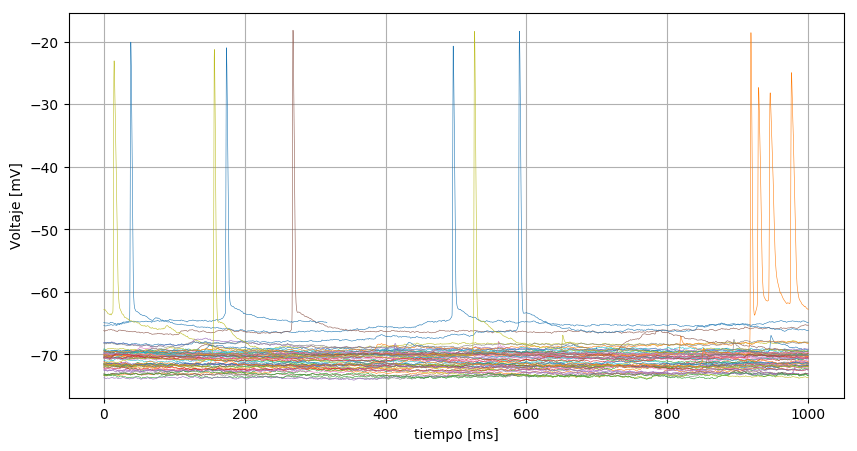

In [19]:
figura=figure(figsize=(10,5))
for subs in keys(suaves)
    lala=length(suaves[subs])
rangot=iart(1, lala)  
 plot(rangot,suaves[subs], label=subs, lw=0.4)
end

xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
#legend()
grid()

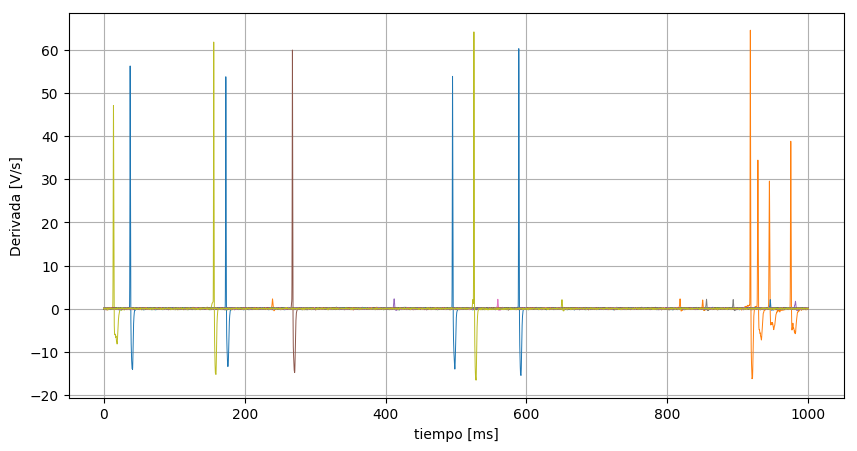

In [20]:
figura=figure(figsize=(10,5))
#ylim(-0.02, 0.5)
for subs in keys(derivadas)
lala=length(derivadas[subs])
rangot=iart(1, lala)    
 plot(rangot,derivadas[subs], label=subs, lw=0.7)
end
xlabel("tiempo [ms]")
ylabel("Derivada [V/s]")
#legend()
grid()

In [21]:
intSS=Dict{String,Dict}()  #intSS es subintervalo del intervalo
for subs in keys(derivadas)
    println(subs)
 intSS[subs]=intervalosP(derivadas[subs], 0.06*freq, 0.4*freq)
end

section_57
section_44
vamos bien, 5738 6988 2.2701333013078084
section_06
no hay naaaaaada en la seccion
section_13
no hay naaaaaada en la seccion
section_17
no hay naaaaaada en la seccion
section_56
section_12
no hay naaaaaada en la seccion
section_41
vamos bien, 21138 22388 2.1848843903079285
section_16
vamos bien, 16009 17259 2.091532496833537
section_09
no hay naaaaaada en la seccion
section_58
section_07
no hay naaaaaada en la seccion
section_43
no hay naaaaaada en la seccion
section_29
no hay naaaaaada en la seccion
section_39
no hay naaaaaada en la seccion
section_40
no hay naaaaaada en la seccion
section_10
no hay naaaaaada en la seccion
section_04
no hay naaaaaada en la seccion
section_45
section_00
no hay naaaaaada en la seccion
section_32
no hay naaaaaada en la seccion
section_36
no hay naaaaaada en la seccion
section_47
no hay naaaaaada en la seccion
section_49
no hay naaaaaada en la seccion
section_46
vamos bien, 24294 25000 1.7132576256088328
section_03
no hay naaaaaada e

In [22]:
intSS

Dict{String,Dict} with 59 entries:
  "section_57" => Dict{Int64,Any}()
  "section_44" => Dict{Int64,Any}(1=>5738:6988)
  "section_06" => Dict{Int64,Any}()
  "section_13" => Dict{Int64,Any}()
  "section_17" => Dict{Int64,Any}()
  "section_56" => Dict{Int64,Any}()
  "section_12" => Dict{Int64,Any}()
  "section_41" => Dict{Int64,Any}(1=>21138:22388)
  "section_16" => Dict{Int64,Any}(1=>16009:17259)
  "section_09" => Dict{Int64,Any}()
  "section_58" => Dict{Int64,Any}()
  "section_07" => Dict{Int64,Any}()
  "section_43" => Dict{Int64,Any}()
  "section_29" => Dict{Int64,Any}()
  "section_39" => Dict{Int64,Any}()
  "section_40" => Dict{Int64,Any}()
  "section_10" => Dict{Int64,Any}()
  "section_04" => Dict{Int64,Any}()
  "section_45" => Dict{Int64,Any}()
  "section_00" => Dict{Int64,Any}()
  "section_32" => Dict{Int64,Any}()
  "section_36" => Dict{Int64,Any}()
  "section_47" => Dict{Int64,Any}()
  "section_49" => Dict{Int64,Any}()
  "section_46" => Dict{Int64,Any}(1=>24294:25000)
  ⋮        

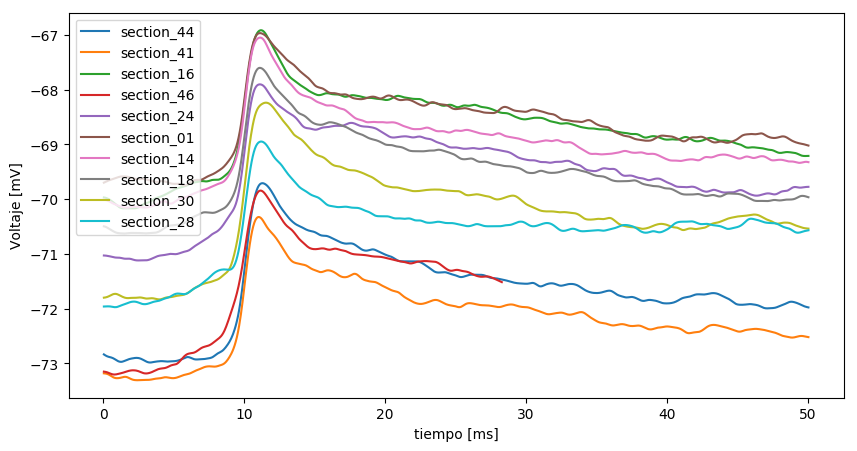

PyObject <matplotlib.legend.Legend object at 0x7fd01c92e860>

In [24]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,suaves[subs][rango], label=subs)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
legend()

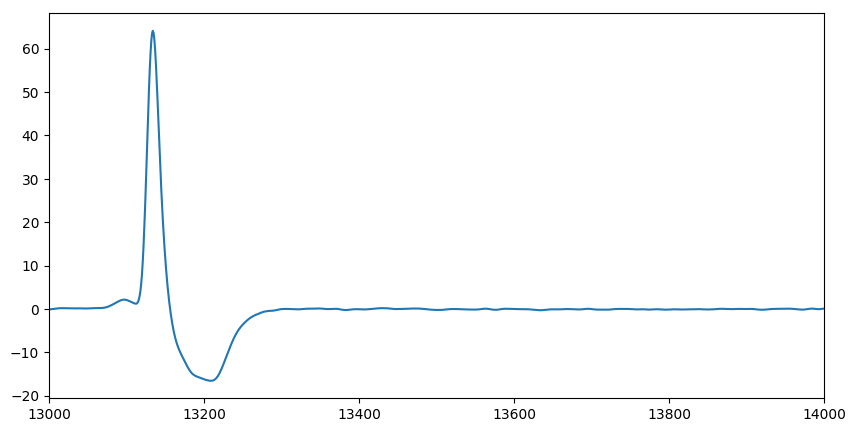

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd01c923470>

In [25]:
figura=figure(figsize=(10,5))
xlim(13000,14000)
#ylim(-0.02,0.1)
  #rango=intSS[subs][1]
plot(derivadas["section_50"])
#plot(suaves["section_50"])

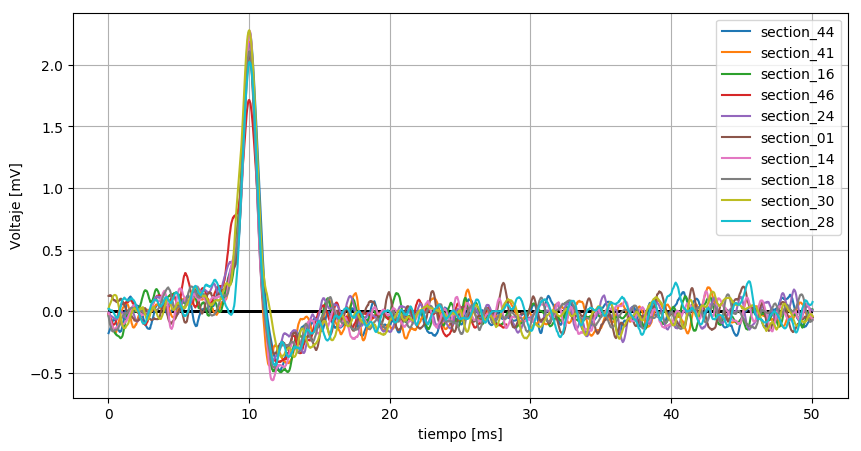

PyObject <matplotlib.legend.Legend object at 0x7fd01cb51be0>

In [26]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,derivadas[subs][rango], label=subs)
        hlines(0, 0, 50,lw=2)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
grid()
legend()

In [27]:
(limpia, mocha)=separamochas(intSS);

In [28]:
ddt=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    ddt[subs]=derivadadt(derivadas[subs])    
end

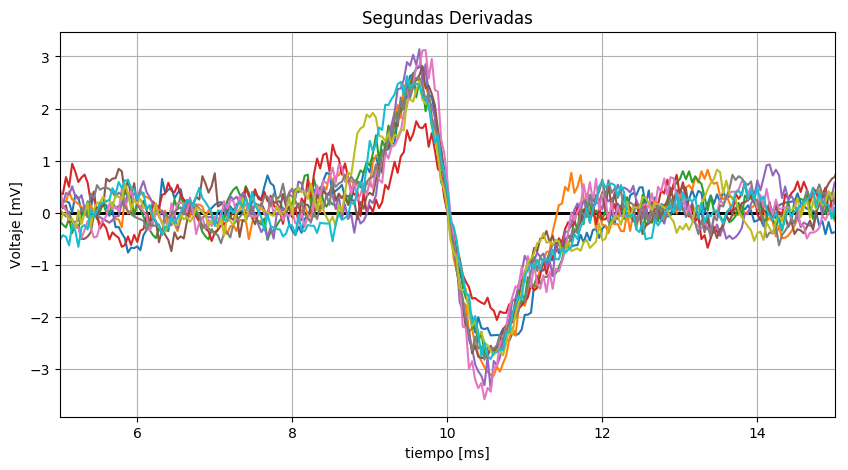

In [30]:
figura=figure(figsize=(10,5))

title("Segundas Derivadas")

xlim(5,15)
# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,ddt[subs][rango], label=subs)
        hlines(0, 0, 50,lw=2)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
grid()
#legend()

In [44]:
promSpk=average1(limpia, suaves); # de ahora en adelante asi se sacan promedios sobre intervalos!


In [32]:
function normCut(datossuave, intervaloslimpios, intervalossospechos)

    a=average1(intervaloslimpios, datossuave) # de ahora en adelante asi se sacan promedios sobre intervalos!
    offset=a[1]
    result=Dict{String,Dict}()
    
   for subs in keys(intervaloslimpios)
    result[subs]=Dict{Int, Array}()
    for j in keys(intervaloslimpios[subs])
         arre=intervalossospechos[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        #normCut[subs][j]=suaves[subs][rango].-(suaves[subs][rango][1]-a[1])
        result[subs][j]=g0(datossuave[subs][rango],a[1]) # g0 es la funcion que empareja el punto de inicio
   
    end
        
    end
    return result
end

normCut (generic function with 1 method)

In [33]:
normalized=normCut(suaves, limpia, intSS)

Dict{String,Dict} with 9 entries:
  "section_16" => Dict{Int64,Array}(1=>[71.2207, 71.2193, 71.2172, 71.2144, 71.…
  "section_18" => Dict{Int64,Array}(1=>[71.2207, 71.2191, 71.2163, 71.2125, 71.…
  "section_44" => Dict{Int64,Array}(1=>[71.2207, 71.2136, 71.207, 71.2007, 71.1…
  "section_14" => Dict{Int64,Array}(1=>[71.2207, 71.2202, 71.2191, 71.2172, 71.…
  "section_24" => Dict{Int64,Array}(1=>[71.2207, 71.2202, 71.2197, 71.2188, 71.…
  "section_30" => Dict{Int64,Array}(1=>[71.2207, 71.2217, 71.2232, 71.2252, 71.…
  "section_28" => Dict{Int64,Array}(1=>[71.2207, 71.2214, 71.2222, 71.2227, 71.…
  "section_01" => Dict{Int64,Array}(1=>[71.2207, 71.2257, 71.2307, 71.2359, 71.…
  "section_41" => Dict{Int64,Array}(1=>[71.2207, 71.2199, 71.2185, 71.2169, 71.…

In [73]:
derivadalimpia=Dict{String, Dict{Int64, Array}}()
for k in keys(normalized)
    derivadalimpia[k]=Dict{Int64,Array}()
    for j in keys(normalized[k])
        derivadalimpia[k][j]=derivadadt(normalized[k][j])
    end
end

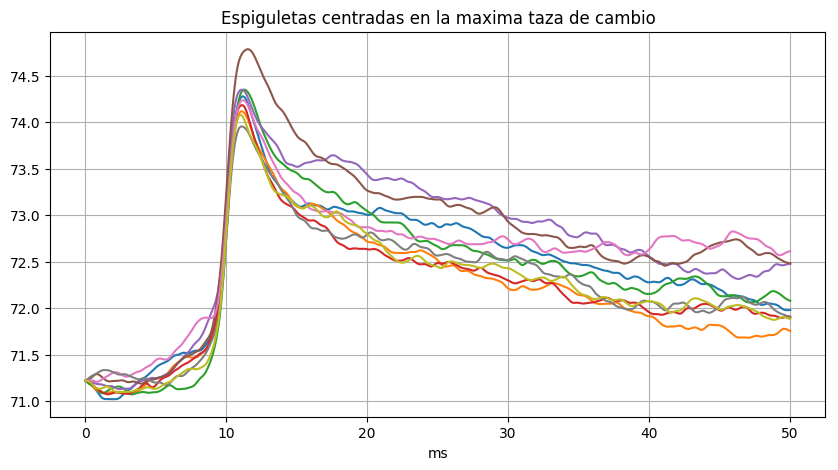

In [35]:
figura=figure(figsize=(10,5))
rangot=0
title("Espiguletas centradas en la maxima taza de cambio")
# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(normalized)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(normalized[subs])
           rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        plot(rangot,normalized[subs][j])
    end
end

 xlabel("ms")
grid()
#plot(a, lw=3)

**NOTA para avanzar**

En la grafica superior, la linea gruesa es el promedio. Nos interesa calcular el tiempo que le lleva levantarse desde
el cambio en la curvatura (suave a muy empinado) hasta el máximo punto de la funcion.

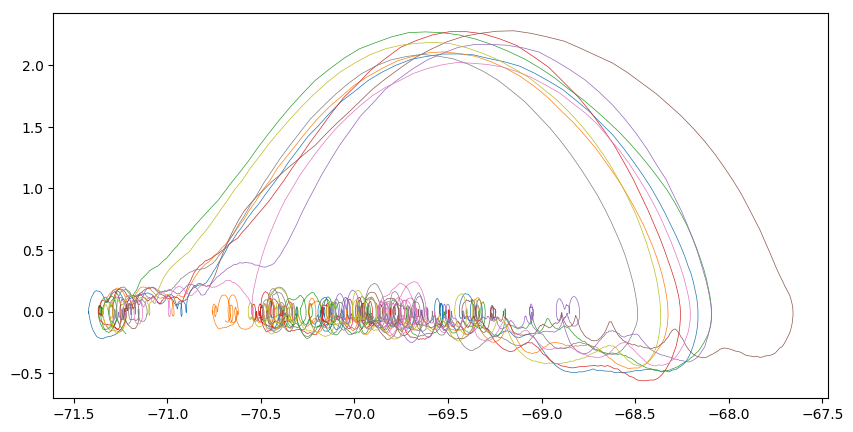

In [36]:

figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(limpia)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(limpia[subs])
        # tomamos el rango de cada subintervalo sospechoso
        arre=limpia[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        plot(suaves[subs][rango].-(suaves[subs][rango][1]-a[1]), derivadas[subs][rango], lw=0.5)
    end
end
#plot(promSpK[2:end],difProm, lw=5, c="red")

In [46]:
difProm=derivadadt(promSpk)
ddprom=derivadadt(difProm);

In [47]:
riset=risetime(difProm)

(217, 280)

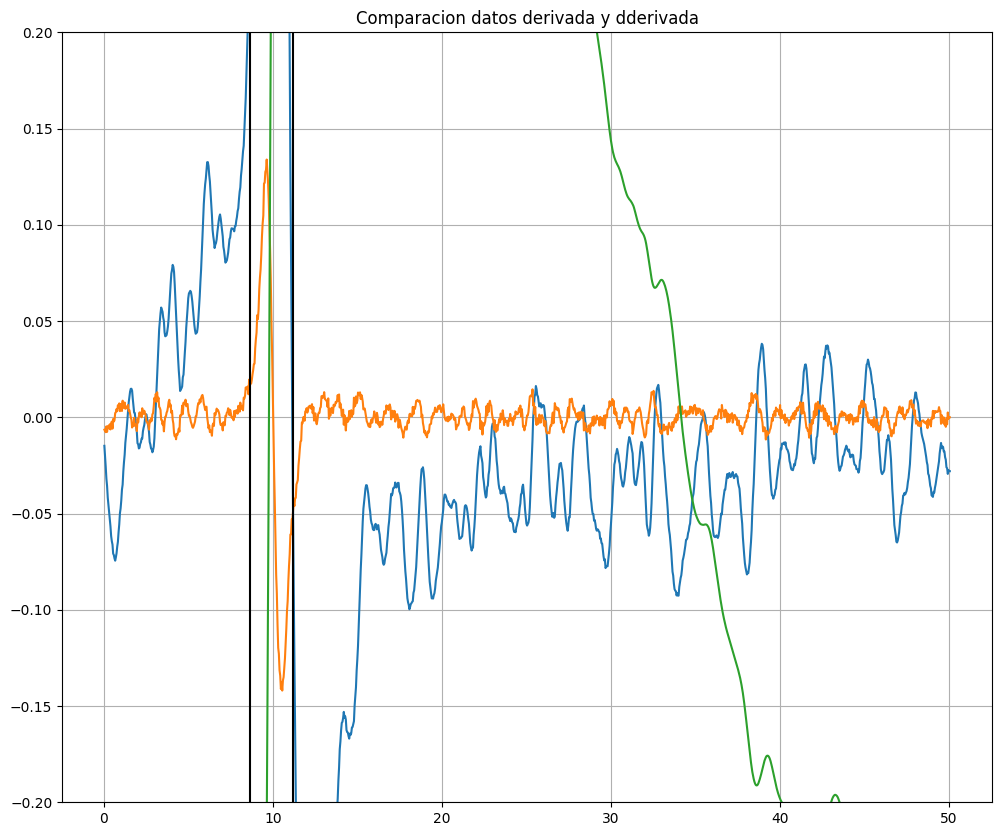

In [49]:
#plot(promSpK)
figure(figsize=(12,10))
title("Comparacion datos derivada y dderivada")
ylim(-0.2,0.2)
plot(rangot,difProm)
plot(rangot,ddprom*0.05)
plot(rangot,promSpk.+70)
axvline(x=riset[1]/freq, c="black")
axvline(x=riset[2]/freq, c="black")

grid()

# Usaremos LsqFit y una funcion perrona para hacer ajuste por cachos

In [50]:
using LsqFit

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/LsqFit/GCdY9.ji for LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1190


### Vamos a arreglar esto para que las xzeros no necesiten los bordes... a no se yo creo si los vamos a tener que poner de todas formas

In [51]:
function lpp(x, xzeros, yzeros, xini, xfin) 

    
    ll=length(xzeros)+1
    
    if ll!=length(yzeros)-1
        error("tu particion no contiene tantos parametros como necesitas \n
            Te puede faltar un y o te sobra un x")
    end
    if (x<=xini || x>=xfin)
        error("x fuera del dominio")
    end
    
     # las m son las pendientes
    mzeros=zeros(ll)
    kzeros=zeros(ll)
    xaux=vcat(xini, xzeros, xfin)   
    #println(xaux)
    
    for k=1:ll
        mzeros[k]=(yzeros[k+1]-yzeros[k])/(xaux[k+1]-xaux[k])
        kzeros[k]=yzeros[k]-mzeros[k]*xaux[k]
    end
    
    y=0
    
    for k=1:ll
        if xaux[k] <= x < xaux[k+1]
     #       println(xaux[k], " ", x, " ", xaux[k+1])
         y = mzeros[k]*x+kzeros[k]
        elseif  x==xfin
                y=yzero[end]
        
        end
    end
    
    return y

end

lpp (generic function with 1 method)

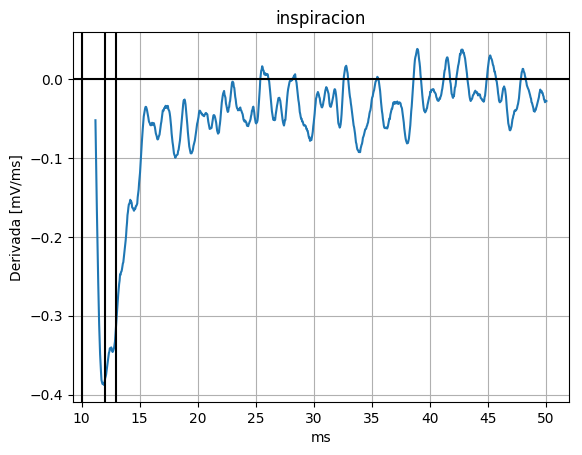

In [54]:
plot(rangot[280:end],difProm[280:end])
xlabel("ms")
ylabel("Derivada [mV/ms]")
axhline([0], c="black")
axvline(10, c="black")
axvline(12, c="black")
axvline(13, c="black")
title("inspiracion")
grid()


# AHORA si es en serio:

In [55]:
ip=round(Int, 10*freq)
ic=findfirst(x->x<0, difProm[250:end])+ip

280

In [56]:
yyforfit=difProm[ic:end]
xxfofit=rangot[ic:end];

In [57]:
xxfofit

11.2:0.04:50.04

In [58]:
xzeros5=[12,13,15.5]
yzeros5=[-0.0001, -0.4,-0.25, -0.05,-0.0001];


5-element Array{Float64,1}:
 -0.0001
 -0.4   
 -0.25  
 -0.05  
 -0.0001

In [59]:
xi=xxfofit[1]
xf=xxfofit[end]
model5(x,p)=map(xr->lpp(xr, p[1:3], p[4:8], xi, xf),x)

model5 (generic function with 1 method)

In [60]:
p_0_5=vcat(xzeros5,yzeros5)

8-element Array{Float64,1}:
 12.0   
 13.0   
 15.5   
 -0.0001
 -0.4   
 -0.25  
 -0.05  
 -0.0001

In [61]:
yys5=map(x->lpp(x, xzeros5, yzeros5,xi,xf), xxfofit[2:end-1]);

In [63]:
fit5 = curve_fit(model5, xxfofit[2:end-1], yyforfit[2:end-1], p_0_5);

In [64]:
pp5=fit5.param

8-element Array{Float64,1}:
 11.703333961471664   
 13.98857731932542    
 15.560009163911978   
 -0.08763190504176102 
 -0.4149414427536649  
 -0.19553542839918314 
 -0.05547088769230578 
 -0.008903043363088463

In [65]:
yyfit5=model5(xxfofit[2:end-1],pp5);

Vamos a sacar nuestro $r^2$


In [66]:
sstot=sum((yyforfit.-mean(yyforfit)).^2)
ssreg=sum((yyfit5.-mean(yyforfit)).^2)
rquad5=1-ssreg/sstot

0.10139589940358107

In [67]:
xzeros4=[12,15.5]
yzeros4=[-0.001,-0.45, -0.05,-0.001]
p_0_4=vcat(xzeros4,yzeros4)
xi=xxfofit[1]
xf=xxfofit[end]
model4(x,p)=map(xr->lpp(xr, p[1:2], p[3:6], xi, xf),x)

model4 (generic function with 1 method)

In [68]:
fit4 = curve_fit(model4, xxfofit[2:end-1], yyforfit[2:end-1], p_0_4)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([11.6995, 15.5248, -0.0876329, -0.412457, -0.0554434, -0.00894261], [-0.0222508, -0.0128604, -0.00200581, 0.00561902, 0.0130616, 0.0149545, 0.0160474, 0.0161259, 0.0101781, 0.00100143  …  0.00588812, 0.00826559, 0.00837157, 0.0114063, 0.0127404, 0.0167473, 0.017294, 0.0203013, 0.0183603, 0.0190079], [0.0520724 0.0 … 0.0 0.0; 0.104145 0.0 … 0.0 0.0; … ; 0.0 -3.1227e-6 … 0.00231782 0.997682; 0.0 -1.56135e-6 … 0.00115891 0.998841], true, Float64[])

In [75]:
typeof(fit4)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}

In [69]:
pp4=fit4.param;
yyfit4=model4(xxfofit[2:end-1],pp4);

### Hasta aqui fue con el promedio:
Ahora hay que hacerlo para cada una de las diferentes derivadas.


In [81]:
ip=round(Int, 10*freq)
ic=findfirst(x->x<0, difProm[250:end])+ip

dictfits=Dict{String,Dict{Int64, Any}}()

# Primero buscamos la lista de los intervalos ejemplo
@time for k in keys(derivadalimpia)
    dictfits[k]=Dict{Int64, Any}()
    for j in keys(derivadalimpia[k])
        aux=derivadalimpia[k][j]
        #el punto donde comienza el ajuste
        ic=findfirst(x->x<0, aux[250:end])+ip
        yyforfit=aux[ic:end]
        xxfofit=rangot[ic:end];
        xi=xxfofit[1]
        xf=xxfofit[end]
        model4(x,p)=map(xr->lpp(xr, p[1:2], p[3:6], xi, xf),x)
        dictfits[k][j]=curve_fit(model4, xxfofit[2:end-1], yyforfit[2:end-1], p_0_4)
    end
end


  8.895356 seconds (70.07 M allocations: 3.026 GiB, 10.68% gc time)


[11.7281, 15.3534, -0.14576, -0.538812, -0.0222472, -0.0418523]


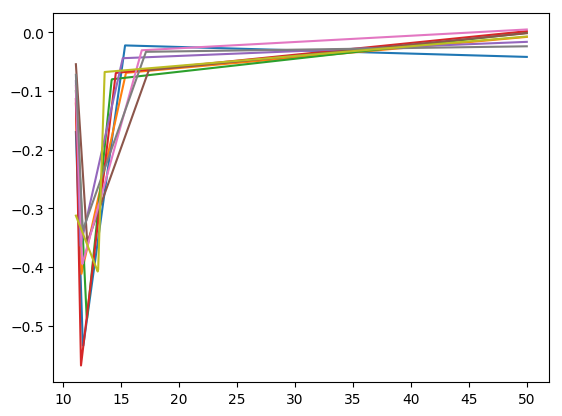

[11.5897, 15.44, -0.0966148, -0.412701, -0.068938, -0.00763932]
[12.0628, 14.2068, -0.0835287, -0.490774, -0.079987, -0.000640439]
[11.5564, 14.5623, -0.0719535, -0.568691, -0.0691427, 0.00211948]
[11.502, 15.16, -0.0534613, -0.36573, -0.0440431, -0.0161183]
[12.0999, 17.4109, -0.0418935, -0.358182, -0.064303, -0.00136603]
[11.6527, 16.8, -0.0684934, -0.396997, -0.0305045, 0.00499789]
[11.7024, 17.1505, -0.0541041, -0.338367, -0.0331534, -0.0237218]
[13.0316, 13.5919, -0.310456, -0.409416, -0.0675809, -0.00697519]


In [85]:
for k in keys(dictfits)
    for j in keys(dictfits[k])
        aux=dictfits[k][j]
        ppp=aux.param;
        println(ppp)
        yyfit4=model4(xxfofit[2:end-1],ppp);
        plot(xxfofit[2:end-1], yyfit4)
    end
end

In [70]:
yyfit4[1:10]

10-element Array{Float64,1}:
 -0.11364396673567967
 -0.1396550127011471 
 -0.16566605866661632
 -0.19167710463208465
 -0.21768815059755386
 -0.2436991965630222 
 -0.2697102425284914 
 -0.29572128849395884
 -0.32173233445942806
 -0.3477433804248964 

In [71]:
yys4=map(x->lpp(x, xzeros4, yzeros4,xi,xf), xxfofit[2:end-1]);

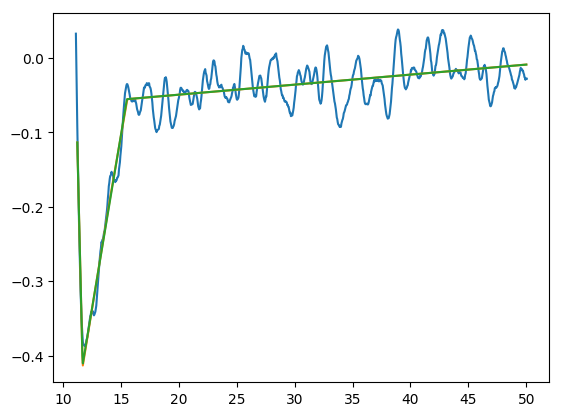

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6e4f518a58>

In [76]:
plot(rangot[278:end],difProm[278:end])
plot(xxfofit[2:end-1], yyfit5)
plot(xxfofit[2:end-1], yyfit4)


In [73]:
sstot=sum((yyforfit.-mean(yyforfit)).^2)
ssreg=sum((yyfit4.-mean(yyforfit)).^2)
rquad4=1-ssreg/sstot

0.10146767330196582

In [65]:
paso=1/freq
tts=0:paso:50

0.0:0.04:50.0

In [66]:
freq

25.0

In [67]:
np=pyimport("numpy")

UndefVarError: UndefVarError: pyimport not defined

In [68]:
piezas=np[:piecewise]
piezas

UndefVarError: UndefVarError: np not defined

## A partir de aquí estamos guardando datos

In [ ]:
using DelimitedFiles

In [ ]:
datos=hcat(promSpK[2:end],difProm)

In [ ]:
writedlm("../h5files/masterspikelet.dat", datos)

In [ ]:
nota="Esta espiguleta es el promedio de todas las detectadas automaticamente con el experimento  "*nomine

In [ ]:
h5open("../h5files/masterspiklet.h5", "w") do file
   write(file, "voltaje", promSpK[2:end])  # alternatively, say "@write file A"
    write(file, "derivative", difProm)  # alternatively, say "@write file A"
    write(file, "nota", nota)  # alternatively, say "@write file A"
end


In [ ]:

test = h5open("../h5files/masterspiklet.h5", "r");
names(test)

In [ ]:
#using HDF5